In [ ]:
%%shell
# This is to load the data from gdrive where we store the dataset for this python script.
pip install gdown
gdown https://drive.google.com/uc?id=1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7
mkdir dataset
unzip /content/speech-emotion-recognition-ravdess-data.zip -d dataset



In [ ]:
!pip3 install helpers

In [ ]:
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np

# A handler to extract mfccs  feature from each voice clip
# Return a 2D ndarray for mfccs as input of the model
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
    #here I put 125 is for cutting the voiceclip to around 4 sec, to make the column of the ndarray identical for train_test set
    mfccs = mfccs[:,:125]
    return mfccs
    

audiodata = []
emotions = []

# Handler to extract the features and emotion in each voice clip and 
# return it into pandas dataframe so that it can be retrieve easily
# there are two column in the D, features which element of 2D ndarray, and another one is string
# for output classes, at here is the 8 the emotions, declared below in the emotions list
for actors in (os.listdir('/content/dataset')):
  counter = 0
  for item in os.listdir('/content/dataset/' + actors):
    emotion = os.path.basename(item).split("-")[2]
    data = extract_features('/content/dataset/{}/{}'.format(actors,item))
    audiodata.append([data,emotion])
    emotions.append(emotion)
    counter+=1

featuresdf = pd.DataFrame(audiodata,columns = ['feature','class_label'])



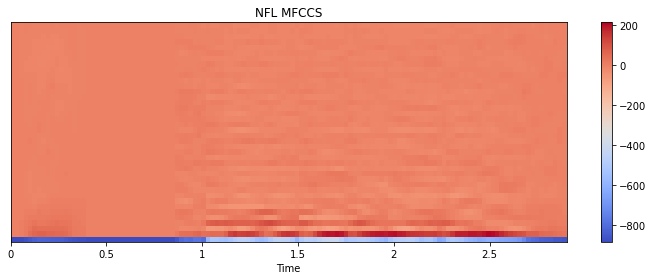

In [ ]:
#A handler to visualise the ndarray of our input
def viewMfcss(mfccs, title):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

viewMfcss(audiodata[0][0],"NFL MFCCS")




In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the output classes into binary vairable from the original string as most of the 
# algorithm work better with numerical inputs
# le = LabelEncoder()
# yy = to_categorical(le.fit_transform(y)) 

test = y[0]
hh=to_categorical(le.fit_transform(y))
print(test)
print(hh[0])



04
[0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
# when we print yyshape, it return (1440,8) meaning that there are 1440 number of 
# output, with the each output having 8 columns
print(yy.shape)

from sklearn.model_selection import train_test_split 

# We use the train_test_split from sklearn for splitting the dataset into 25% test-set and the rest is trainning set
# The random state is to ensures that the splits generate are reproducible.
# Random state used as a seed to the random number generator to ensure the random number are generated in same order
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.25, random_state = 42)



(1440, 8)
40


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

# the numRows indicate the shape we set at extract feature, n_mfccs=40
# numCols is the length of of each input feature matrix, we set it at 125 to fix the training matrix size to 125
# numChans is 1 signifying that the images are greyscale
numRows = 40
numCols = 125
numChans = 1

# the x_train and x_test need to be reshape so that it can input into CNN model
# x_train.shape[0] return the number of input data for 
x_train= x_train.reshape(x_train.shape[0],numRows,numCols,numChans)
x_test = x_test.reshape(x_test.shape[0],numRows,numCols,numChans)



In [ ]:
# Buuild a CNN model with 4 Conv2d layer, as they will deal with our input matrix, which are the 2D metrices.
# the 16, 32,64 128 are the number of nodes in each layer.This number can be higher or lower,
# depending on the size of hte dataset.
# Pooling layers provide an approach to down sampling feature maps by summarizing the presence of features in patches of the feature map.
# The addition of a pooling layer after the convolutional layer is a common pattern used for ordering layers within a convolutional neural network that may be repeated one or more times in a given model.
# The pooling layer operates upon each feature map separately to create a new set of the same number of pooled feature maps.
model = Sequential()
model.add(Conv2D(16, (2,2), input_shape=(numRows, numCols, numChans), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

numLabels = yy.shape[1]
model.add(Dense(numLabels, activation='softmax'))

# we use categorical_crossentropy as loss function because this is a classification problem 
# the optimizer is adam as it provide a suitable learning rate for most of the machine learning problem
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()


In [ ]:
from datetime import datetime 

# Normalization as per the standard NN process
def normalization(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mean)/std
    return X
start = datetime.now()

x_train = normalization(x_train)
x_test = normalization(x_test)
history = model.fit(x_train, y_train, batch_size=256, epochs=250, validation_data=(x_test, y_test), verbose=0, use_multiprocessing=True)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Training completed in time:  0:14:18.137550


Training Accuracy:  1.0
Testing Accuracy:  0.5638889074325562


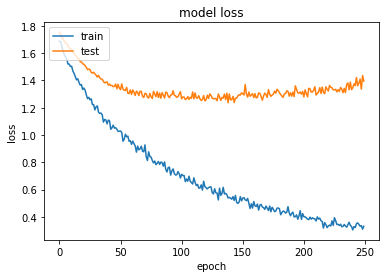

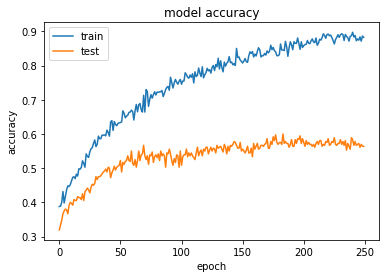

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



[0. 0. 0. 1. 0. 0. 0. 0.]
3
              precision    recall  f1-score   support

           0       0.68      0.61      0.64        28
           1       0.70      0.88      0.78        42
           2       0.53      0.69      0.60        42
           3       0.74      0.60      0.67        53
           4       0.81      0.71      0.76        55
           5       0.79      0.60      0.68        50
           6       0.70      0.76      0.73        42
           7       0.79      0.85      0.82        48

    accuracy                           0.71       360
   macro avg       0.72      0.71      0.71       360
weighted avg       0.73      0.71      0.71       360



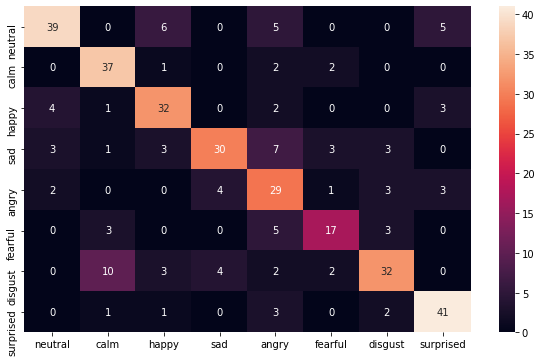

In [ ]:
import sklearn.metrics as mt 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix

actual_y_conf = []
predict_y_conf = []

emotion=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
pred_y = np.argmax(model.predict(x_test),1)
actual_y = np.argmax(y_test,1)
print(y_test[0])
print(actual_y[0])

for i in range(0,y_test.shape[0]):
  actual_emo = emotion[actual_y[i]]
  predicted_emo = emotion[pred_y[i]]
  actual_y_conf.append(actual_emo)
  predict_y_conf.append(predicted_emo)

cm = confusion_matrix(actual_y_conf,predict_y_conf)
print(mt.classification_report(actual_y,pred_y))
index = emotion
columns = emotion
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True) 




